<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.SmokerStatusPrediction/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [3]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1 # e.g. 1
MODELS_TRIAL = 1 # e.g. 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/11.SmokerStatusPrediction/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [15]:
df_source = pd.read_csv(manager.train_path, index_col=0)
df_submission_source = pd.read_csv(manager.test_path, index_col=0)

df_source.shape, df_submission_source.shape

((159256, 23), (106171, 22))

In [16]:
df_source.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
id,,,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [18]:
df_submission_source.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
id,,,,,,,,,,,,,,,,,,,,,,
159256,40,165,70,84.0,1.2,1.2,1,1,130,89,107,200,186,49,115,14.2,1,0.9,19,25,32,0
159257,80,160,60,93.0,1.0,1.0,2,2,144,72,93,172,158,35,104,13.0,1,1.1,20,12,24,0
159258,60,170,70,86.5,0.6,0.7,1,1,117,75,92,161,173,39,88,15.4,1,1.4,38,60,36,0
159259,40,160,50,67.0,0.3,0.4,1,1,116,62,91,213,47,75,128,14.5,1,0.6,25,18,10,1
159260,40,170,75,89.4,1.0,0.9,1,1,132,94,79,170,100,39,123,16.5,1,1.0,30,39,27,1


# Quick look on the data

In [10]:
from sklearn_utils import nan_report

nan_report(df_source, 0.0)
nan_report(df_submission_source, 0.0)

0 / 24 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)
0 / 23 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


Series([], dtype: float64)

In [12]:
from sklearn_utils import inf_report

inf_report(df_source, 0.0)
inf_report(df_submission_source, 0.0)

No infinite values observed
No infinite values observed


,inf_percent


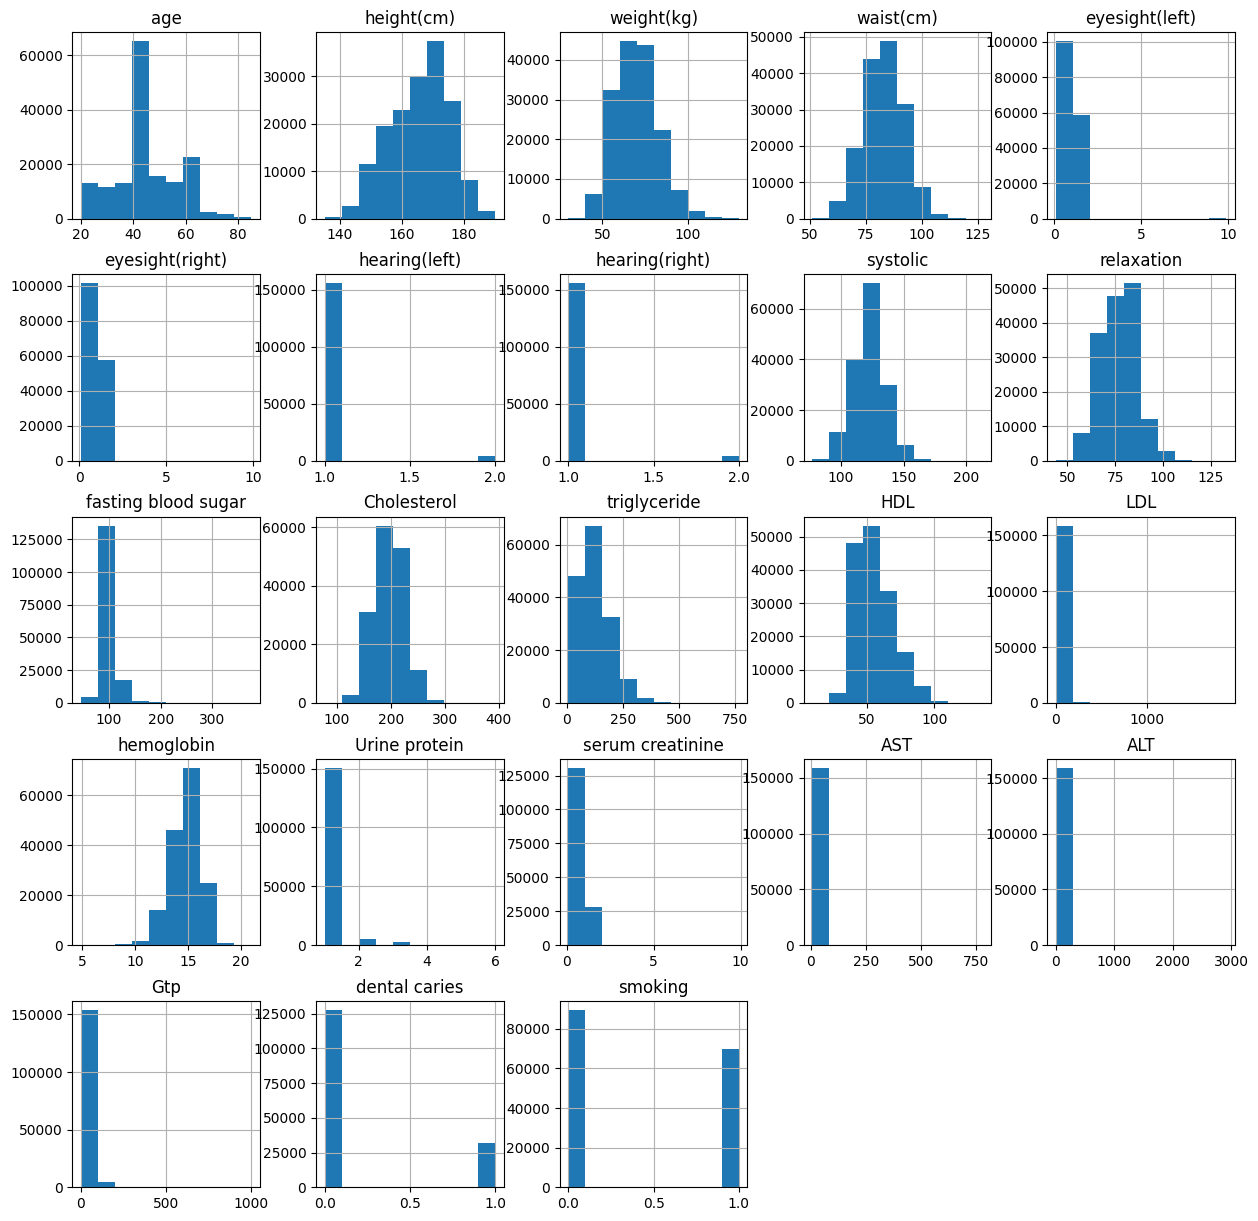

In [19]:
_ = df_source.hist(
    figsize=(15, 15),
    # layout=()
)

Visualizing datasets distributions
(8, 3) <class 'numpy.ndarray'>


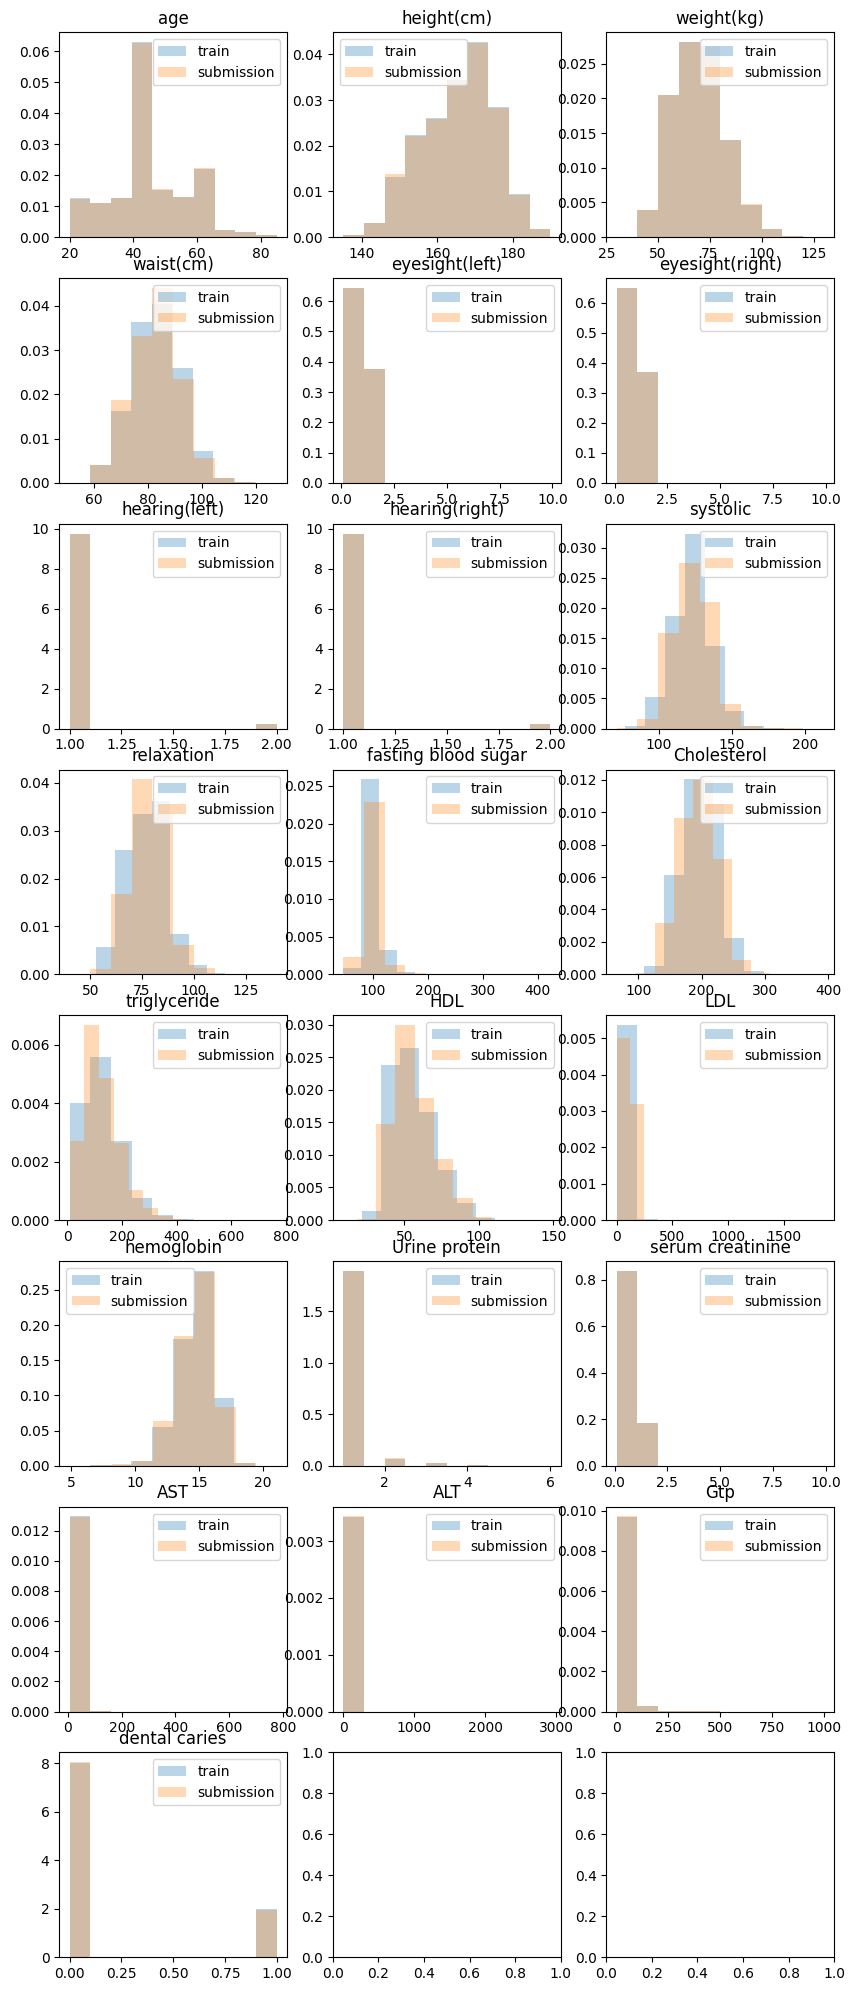

In [20]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'train': df_source,
        'submission': df_submission_source
    },
    columns=df_submission_source.columns
)

# Data cleaning

In [22]:
df_source.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [21]:
df_source['eyesight(left)'].max()

9.9

# Data split

<Axes: >

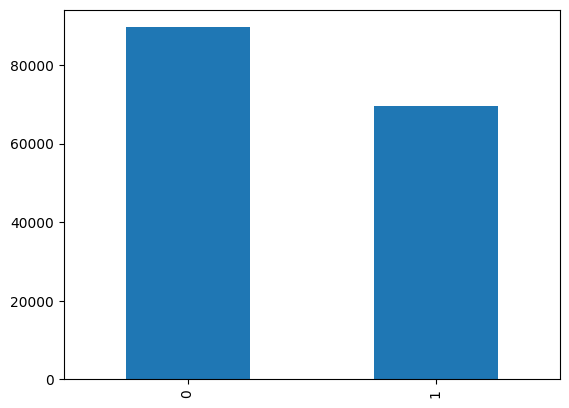

In [24]:
df_source['smoking'].value_counts().plot(kind='bar')

In [25]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TRAIN_SIZE = 0.8

df_train, df_val = train_test_split(
    df_source,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_source['smoking']
)

df_train.shape, df_val.shape

((127404, 23), (31852, 23))

In [35]:
def X_Y(df, include_y=True):
    X = df.iloc[:, np.isin(df.columns, ['smoking'])]
    if include_y:
        Y = df['smoking']
    else:
        Y = None

    return X, Y

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)
X_submission, _ = X_Y(df_submission_source, include_y=False)

In [36]:
Xs = [
    X_train,
    X_val,
    X_submission
]

Ys = [
    Y_train,
    Y_val,
    None
]

# Baseline

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
est = LogisticRegression()

In [31]:
df_train.iloc[:, ~np.isin(df_train.columns, ['smoking'])].shape

(127404, 22)

In [32]:
est.fit(
    X=df_train.iloc[:, ~np.isin(df_train.columns, ['smoking'])],
    y=df_train['smoking']
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
from sklearn.metrics import accuracy_score

accuracy_score(
    est.predict(df_val.iloc[:, ~np.isin(df_val.columns, ['smoking'])]),
    df_val['smoking']
)

0.7320105487881452